# Part A

• **DOMAIN**: Botanical Research

• **CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have have invested on curating sample images. They require an automation which can create a classifier capable of determining a plant's species from a photo.

• **DATA DESCRIPTION**: The dataset comprises of images from 12 plant species.
Source: https://www.kaggle.com/c/plant-seedlings-classification/data.

• **PROJECT OBJECTIVE**: To create a classifier capable of determining a plant's species from a photo.

**Steps and tasks:**

In [1]:
#!pip install natsort

In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image , ImageFilter
import shutil
from natsort import natsorted
from glob import glob
import glob
from sklearn.utils import shuffle
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
import cv2
from sklearn import svm, metrics
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv2D,MaxPooling2D 
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import itertools
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

#### 1. Import and Understand the data

##### A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.

In [3]:
with zipfile.ZipFile("D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART A/plant-seedlings-classification.zip","r") as zip_ref:
    zip_ref.extractall("D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART A")

##### B. Map the images from train folder with train labels to form a DataFrame

In [4]:
paths = glob.glob("D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART A/plant-seedlings-classification/train/*")
label_names = [os.path.split(x)[-1] for x in paths]

print("Total number of plant species: {}".format(len(label_names)))
print("species name: {}".format(label_names))

Total number of plant species: 12
species name: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


##### C. Write a function that will select n random images and display images along with its species.

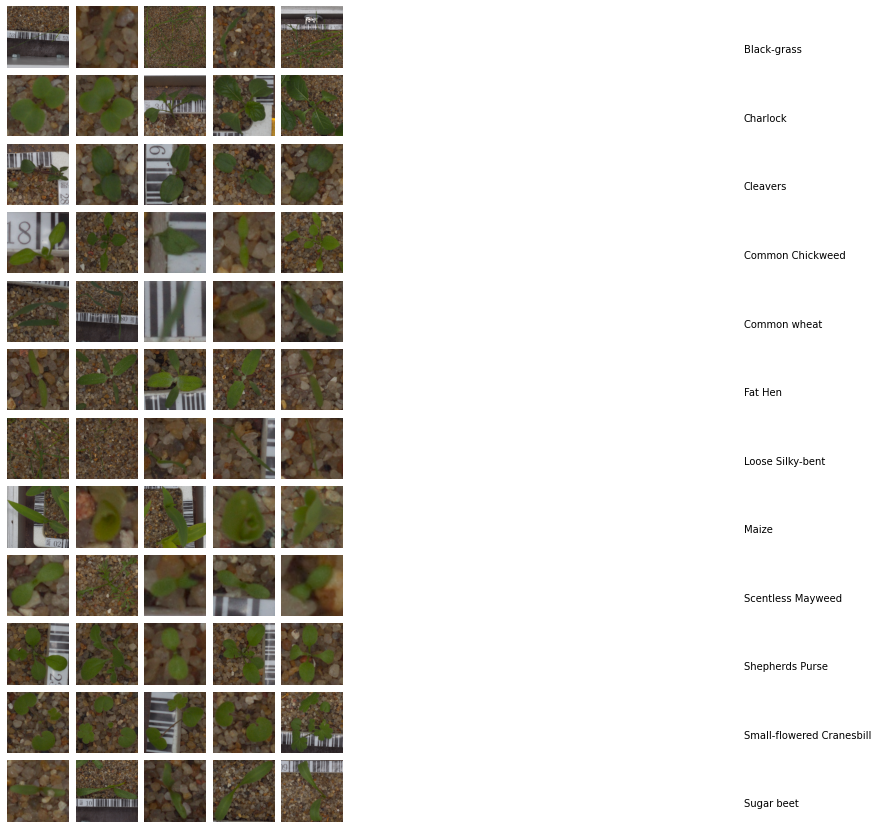

In [5]:
fig = plt.figure(1, (20, 15))

#If input for function is 5, it prints 5 random images along with its labels.
grid = ImageGrid(fig, 111, nrows_ncols=(12, 5), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART A/plant-seedlings-classification/train", label, "*.png"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=5) #If input for function is 5, it prints 5 random images along with its labels.

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

In [6]:
img.shape

(150, 150, 3)

--------------------

#### 2. Data preprocessing

**Reading Images**

In this step, we simply store the path to our image dataset into a variable and then we create a function to load folders containing images into arrays so that computers can deal with it.

In [7]:
#save the path into variable to use it easily next times.
TRAIN_PLANT_SPECIES= "D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART A/plant-seedlings-classification/train"

##### A. Create X & Y from the DataFrame.

In [8]:
from glob import glob
X = []
Y = []
missing=0
for Y_folder_name in os.listdir(TRAIN_PLANT_SPECIES):
    Y_folder_path = os.path.join(TRAIN_PLANT_SPECIES, Y_folder_name)
    Y_label = Y_folder_name
    
    for image_path in glob(os.path.join(Y_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        X.append(image_bgr)
        
        Y.append(Y_label)

In [9]:
len(X)

4750

##### C. Unify shape of all the images.

**Resizing images**

Some images captured by a camera and fed to our AI algorithm vary in size, therefore, we should establish a base size for all images fed into our AI algorithms by resizing them.

In [10]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
X = [resize_images(img) for img in X]

In [11]:
X[0].shape

(256, 256, 3)

In [12]:
#see number of images in each label
X = np.array(X)
Y = np.array(Y)
print("X shape:",X.shape)
print("Y shape:",Y.shape)

X shape: (4750, 256, 256, 3)
Y shape: (4750,)


#### Viewing the distribution of number of images in each species and
##### D. Normalise all the images.

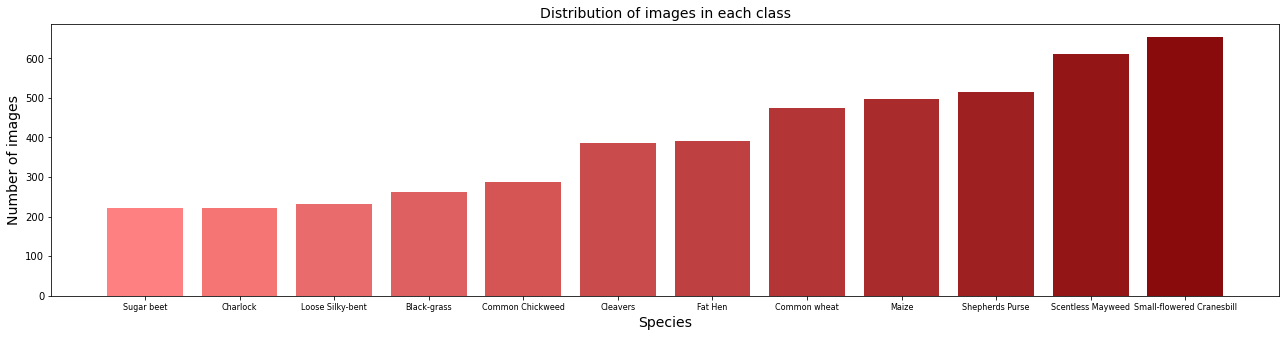

In [13]:
values =[]
labels=[]
for label in set(Y):
  values.append(len(X[Y == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize() #Normalised
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,5))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

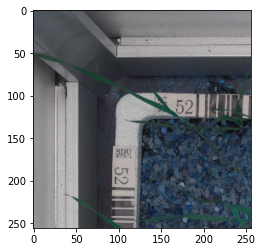

In [14]:
#Normalized
plt.imshow(X[50])

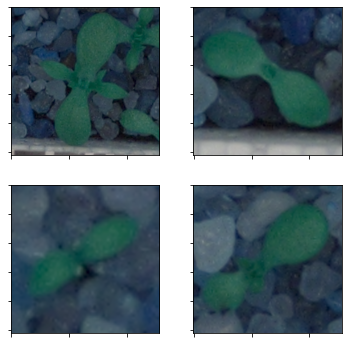

In [15]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =X[Y== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

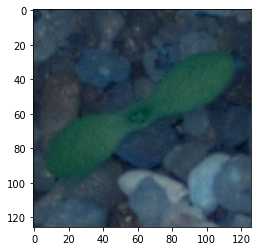

In [16]:
img = cv2.imread("D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART A/plant-seedlings-classification/train/Scentless Mayweed/1300c3cd9.png")
plt.imshow(img)

##### Image Preprocessing

##### Converting images from RGB to HSV and applying mophological transformations

In [17]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

##### Applying Segmentation

In [18]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

##### Applying Sharpening

In [19]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

##### Combining all functions

In [20]:
def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(X):
  try:
    X[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

##### Viewing the pre-processed images

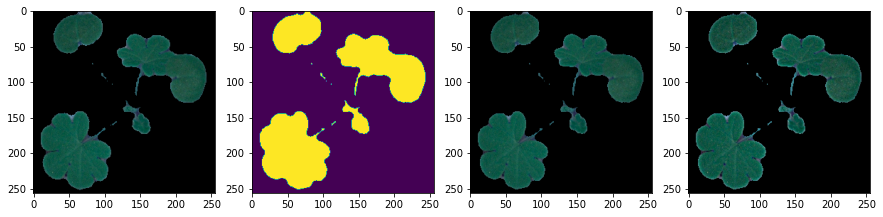

In [21]:
X = np.array(X)
Y = np.array(Y)
image = X[Y == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [22]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [23]:
number_of_columns = X[1].shape[0] * X[1].shape[1]
print(number_of_columns)

65536


##### B. Encode labels of the images.

In [24]:
enc = LabelEncoder()
Y_label = enc.fit_transform(Y)


num_classes = len(np.unique(Y_label))
num_classes

12

In [25]:
print(Y[10])
print(Y_label[10])

print()

print(Y[800])
print(Y_label[800])

Black-grass
0

Cleavers
2


-----------

#### 3. Model training

##### A. Split the data into train and test data.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_label, test_size=0.3, random_state=50)

##### Creating validation set

splitting test and validation sets each with 50% of data

In [27]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [28]:
print(f"Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

Shapes of Train, Test and Validation sets are: (3325, 256, 256, 3),(712, 256, 256, 3),(713, 256, 256, 3)


In [29]:
print(f"Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

Shapes of Train, Test and Validation sets of Target are: (3325,),(712,),(713,)


##### B. Create new CNN architecture to train the model.

In [30]:
def cnn_model(height, width, num_channels, num_classes, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
    
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))
    
  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [31]:
cnn = cnn_model(256,256,3,12)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                        

C:\Users\Nikhila KG\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


##### C. Train the model on train data and validate on test data.

#### We will train without Data Augmentation.

In [32]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = None)

Epoch 1/50
104/104 [==============================] - 600s 6s/step - loss: 2.8027 - accuracy: 0.1194 - val_loss: 2.4344 - val_accuracy: 0.1262
Epoch 2/50
104/104 [==============================] - 610s 6s/step - loss: 2.3782 - accuracy: 0.1841 - val_loss: 2.2666 - val_accuracy: 0.2426
Epoch 3/50
104/104 [==============================] - 609s 6s/step - loss: 2.1474 - accuracy: 0.2424 - val_loss: 2.0743 - val_accuracy: 0.2595
Epoch 4/50
104/104 [==============================] - 610s 6s/step - loss: 2.0635 - accuracy: 0.2671 - val_loss: 2.0488 - val_accuracy: 0.2959
Epoch 5/50
104/104 [==============================] - 610s 6s/step - loss: 2.0027 - accuracy: 0.2704 - val_loss: 2.3671 - val_accuracy: 0.1332
Epoch 6/50
104/104 [==============================] - 613s 6s/step - loss: 1.9739 - accuracy: 0.2917 - val_loss: 1.8611 - val_accuracy: 0.3506
Epoch 7/50
104/104 [==============================] - 611s 6s/step - loss: 1.8074 - accuracy: 0.3468 - val_loss: 1.7314 - val_accuracy: 0.4348

In [33]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)

23/23 [==============================] - 17s 721ms/step - loss: 0.6225 - accuracy: 0.7865
Test loss: 0.6225411295890808
Test accuracy: 0.7865168452262878


##### D. Select a random image and print actual label and predicted label for the same.

In [34]:
predictions = cnn.predict(X_test)

23/23 [==============================] - 17s 720ms/step


In [35]:
class_names = enc.classes_

In [36]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(12))
  plt.yticks([])
  thisplot = plt.bar(range(12), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [37]:
predictions[0]
#This value means confidence that corresponds to 12 species, and we can find the highest confidence by np.argmax

array([1.4658618e-01, 9.6719839e-07, 1.9617602e-05, 2.7726348e-05,
       3.3492858e-03, 4.8336475e-03, 8.4242851e-01, 1.7629829e-06,
       2.6478348e-03, 4.8211132e-06, 6.2559266e-05, 3.7105383e-05],
      dtype=float32)

In [38]:
np.argmax(predictions[0])

6

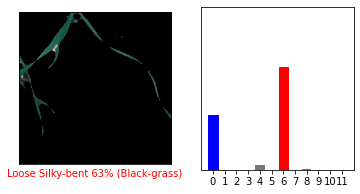

In [39]:
i = 17
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

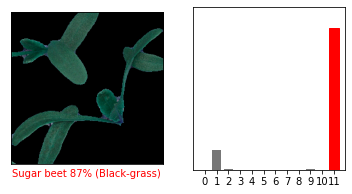

In [40]:
i = 11
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

-------------

# Part B

• **DOMAIN**: Botanical Research

• **CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s species from a photo.

• **DATA DESCRIPTION**: The dataset comprises of images from 17 plant species.

• **PROJECT OBJECTIVE**: To experiment with various approaches to train an image classifier to predict type of flower from the image.

**Steps and tasks**:

In [5]:
os.getcwd()

'D:\\Nikhila\\PGP - AIML\\2. Projects\\8. Computer Vision\\PART B'

In [4]:
os.chdir('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART B')

#### 1. Import and Understand the data

##### A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [6]:
#!pip install tflearn

In [7]:
import tflearn
import tflearn.datasets.oxflower17 as oxflower17

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [8]:
X, y = oxflower17.load_data(resize_pics=(224,224))

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


##### B. Print Number of images and shape of the images.

In [9]:
print('X Shape',X.shape) 
print('y shape',y.shape)

X Shape (1360, 224, 224, 3)
y shape (1360,)


##### C. Print count of each class from y.

In [10]:
print("Total labels: {}".format(len(np.unique(y))))
print("Labels: {}".format(y))

Total labels: 17
Labels: [16  9 16 ...  8 10  1]


In [11]:
X_count = np.asarray(X)
Y_count = pd.DataFrame(y)

Y_count.rename(columns={0:'plant_species'},inplace=True)
Y_count['plant_species'].value_counts()

16    80
8     80
5     80
15    80
12    80
13    80
7     80
10    80
14    80
9     80
6     80
1     80
2     80
4     80
0     80
3     80
11    80
Name: plant_species, dtype: int64

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16')]

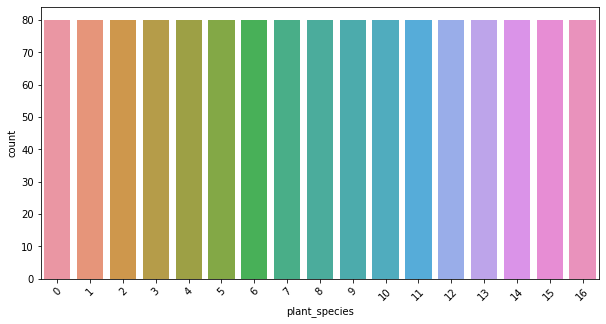

In [12]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=Y_count,
    x='plant_species'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

#### 2. Image Exploration & Transformation [Learning purpose - Not related to final model]

Lets download image dataset in archive format from a URL and carry out further analysis.

In [13]:
import tarfile
import urllib

In [14]:
def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath

In [15]:
#only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

In [16]:
# extract function
def untar(fname,path="17category-flowers-py"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="17category-flowers-py", members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Nikhila KG\AppData\Local\Temp\ipykernel_11532\2033600636.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if path is "":


In [17]:
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","17category-flowers-py")

('Succesfully downloaded', '17flowers.tgz', 60270631, 'bytes.')
File Extracted in to  17category-flowers-py


'17category-flowers-py\\17flowers.tgz'

##### A. Display 5 random images.

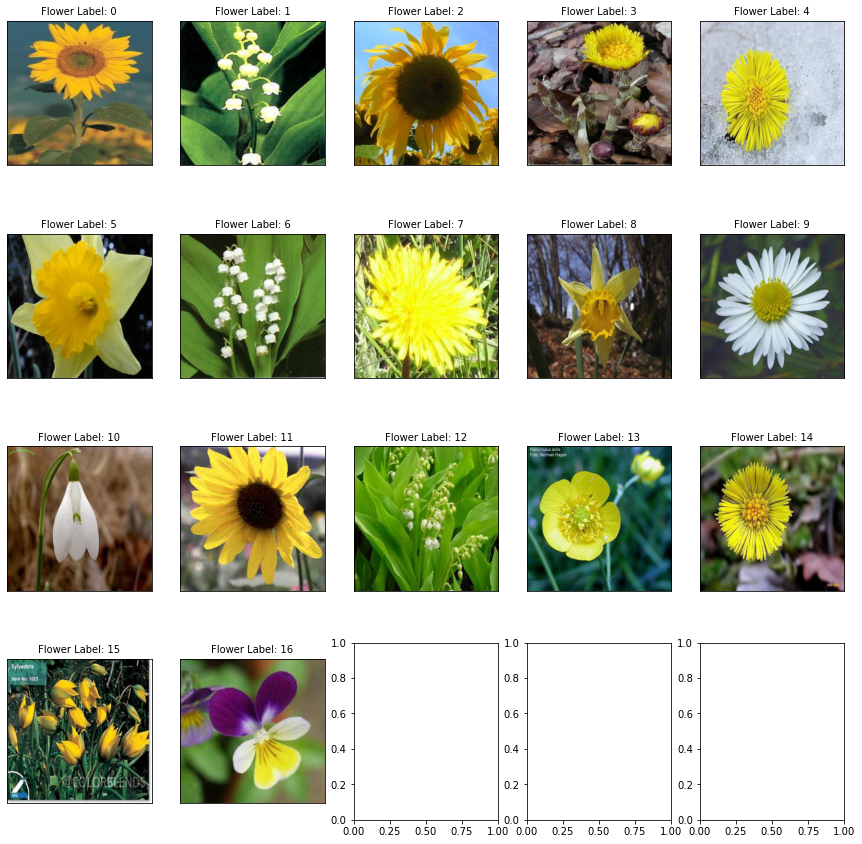

In [18]:
#Lets display one image from each class

cols = 5
rows = int(np.ceil(len(np.unique(y))/cols))

fig, ax = plt.subplots(rows, cols, figsize=(15,15))
for i in np.unique(y):
  col = i % 5
  row = int(i/5)

  ax[row][col].imshow(X[i])
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  ax[row][col].set_title(f"Flower Label: {i}",{'fontsize':10})
plt.show() 

##### B. Select any image from the dataset and assign it to a variable.

In [19]:
#Lets select Img_1291 (randomly choosen) and store in variable called random_img
random_img = Image.open('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART B/17category-flowers-py/jpg/image_1291.jpg')

##### C. Transform the image into grayscale format and display the same.

Original


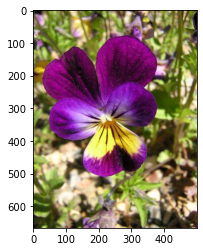

In [20]:
print("Original")
plt.imshow(random_img)

Greyscale


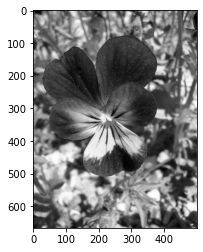

In [21]:
print("Greyscale")
gray_img = random_img.convert("LA")
plt.imshow(gray_img, cmap='gray')

##### D. Apply a filter to sharpen the image and display the image before and after sharpening.

Text(0.5, 0, 'Sharpened')

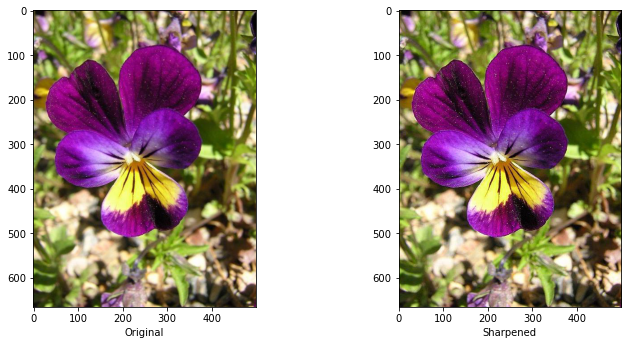

In [22]:
sharpen_img = random_img.filter(ImageFilter.SHARPEN)
plt.figure(figsize=(12,12))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(2,2,1)
plt.imshow(np.asarray(random_img))
plt.xlabel('Original')
plt.subplot(2,2,2)
plt.imshow(np.asarray(sharpen_img))
plt.xlabel('Sharpened')

##### E. Apply a filter to blur the image and display the image before and after blur.

Text(0.5, 0, 'Blured')

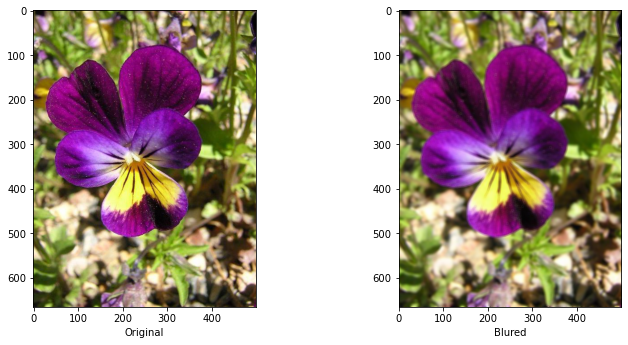

In [23]:
blurred_img = random_img.filter(ImageFilter.BLUR)
plt.figure(figsize=(12,12))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(2,2,1)
plt.imshow(np.asarray(random_img))
plt.xlabel('Original')
plt.subplot(2,2,2)
plt.imshow(np.asarray(blurred_img))
plt.xlabel('Blured')

##### F. Display all the 4 images from above questions besides each other to observe the difference.

Text(0.5, 1.0, 'Blured')

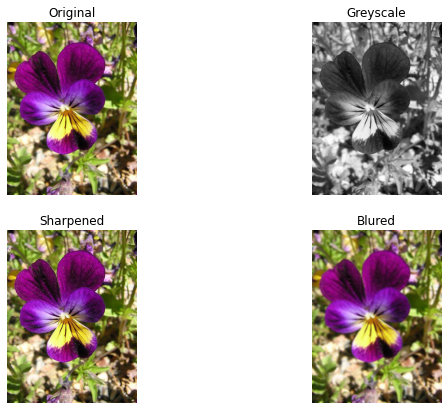

In [24]:
# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(random_img)
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(gray_img)
plt.axis('off')
plt.title("Greyscale")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(sharpen_img)
plt.axis('off')
plt.title("Sharpened")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(blurred_img)
plt.axis('off')
plt.title("Blured")

--------------

#### 3. Model training and Tuning:

##### Data Pre -processing

In [25]:
X,y = oxflower17.load_data(one_hot= False)

In [26]:
project_path = "D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART B/17flowers/jpg"
img_size = 224
img_depth = 3
X_new =[]
y_new = []

In [27]:
os.chdir(project_path)
os.listdir()

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'files.txt',
 'files.txt~']

In [28]:
#Making list for easy traverse
l = os.listdir()
l.remove("files.txt")
l.remove("files.txt~")
print(l)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9']


In [29]:
#Loading data from CWD 
for i in l:
  #print(i)
  for j in os.listdir(i):
    #print(project_path + '/' + i + '/' + j)
    temp = cv2.imread(project_path + '/' + i + '/' + j)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    temp_resize = cv2.resize(temp, (img_size, img_size))
    X_new.append(temp_resize)
    y_new.append(i)

In [30]:
X_new = np.array(X_new)
print("Dimesions of data : ", X_new.shape)

Dimesions of data :  (1360, 224, 224, 3)


In [31]:
y_new = np.array(y_new)
print("Dimesions of labels : ", y_new.shape)

Dimesions of labels :  (1360,)


In [32]:
print("Image size : ", X_new[0].shape)

Image size :  (224, 224, 3)


In [33]:
y_new[:5]

array(['0', '0', '0', '0', '0'], dtype='<U2')

##### A. Split the data into train and test with 80:20 proportion.

In [34]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, shuffle = True, random_state = 42, stratify = y_new)

In [35]:
print("Dimesions of training data : ", X_train.shape)
print("Dimesions of testing data : ", X_test.shape)

Dimesions of training data :  (1088, 224, 224, 3)
Dimesions of testing data :  (272, 224, 224, 3)


In [36]:
# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

In [37]:
# Declaring no. of classes variable
num_classes = 17 # 0 - 16
print("No. of Classes : ", num_classes)

No. of Classes :  17


In [38]:
#One hot encoding the train labels
y_train = tf.keras.utils.to_categorical(y_train,num_classes) 

#One hot encoding the test labels
y_test = tf.keras.utils.to_categorical(y_test,num_classes)

In [39]:
#Normalize both the train and test image data from 0-255 to 0-1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [40]:
#Reshaping the image data
X_train = X_train.reshape(X_train.shape[0],img_size,img_size,img_depth) 
X_test = X_test.reshape(X_test.shape[0],img_size,img_size,img_depth)

In [41]:
np.unique(y_new)

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4',
       '5', '6', '7', '8', '9'], dtype='<U2')

In [42]:
l_new = []
for i in range(0, len(l)): 
  l_new.append(int(l[i]))

l_new.sort()
print(l_new)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [43]:
classes = ['Daffodil','Snowdrop','LilyValley','Bluebell','Crocus','Iris','Tigerlily','Tulip','Fritillary','Sunflower','Daisy','ColtisFoot','Dandelion','Cowslip','Buttercup','Windflower','Pansy']

In [44]:
# using dictionary comprehension 
# to convert lists to dictionary 
Labels = {l_new[i]: classes[i] for i in range(len(l_new))} 
  
# Printing resultant dictionary  
print ("Labels is : " +  str(Labels))

Labels is : {0: 'Daffodil', 1: 'Snowdrop', 2: 'LilyValley', 3: 'Bluebell', 4: 'Crocus', 5: 'Iris', 6: 'Tigerlily', 7: 'Tulip', 8: 'Fritillary', 9: 'Sunflower', 10: 'Daisy', 11: 'ColtisFoot', 12: 'Dandelion', 13: 'Cowslip', 14: 'Buttercup', 15: 'Windflower', 16: 'Pansy'}


In [45]:
#Creating DataFrame for storing the accuracies of all different models
col_names = ['Model', 'Accuracy']
resultsdf = pd.DataFrame(columns = col_names)
print(resultsdf)

Empty DataFrame
Columns: [Model, Accuracy]
Index: []


##### B. Train a model using any Supervised Learning algorithm and share performance metrics on test data.

In [46]:
print("Actual training data shape : ", X_train.shape)

Actual training data shape :  (1088, 224, 224, 3)


In [47]:
print("Actual training label shape : ", y_train.shape)

Actual training label shape :  (1088, 17)


In [48]:
#Flattening the traning data
nsamples, nx, ny, nz = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny*nz))

In [49]:
#Flattening the testing data
nsamples, nx, ny, nz = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny*nz))

In [50]:
print("After flattening training data shape : " ,d2_X_train.shape)

After flattening training data shape :  (1088, 150528)


In [51]:
print("After flattening testing data shape : " ,d2_X_test.shape)

After flattening testing data shape :  (272, 150528)


In [52]:
# Declaring MultinomialNB Classifier
clf = MultinomialNB()

In [53]:
# Training model
clf.fit(d2_X_train,(np.argmax(y_train ,axis=-1)))

MultinomialNB()

In [54]:
# Predicting for all of test dataset
pred = clf.predict(d2_X_test)

print("Accuracy Score of training set: {}".format(accuracy_score(np.argmax(y_train, axis=1),clf.predict(d2_X_train)))) 
print("Accuracy Score of testing set: {}".format(accuracy_score(np.argmax(y_test, axis=1),pred)))

Accuracy Score of training set: 0.5183823529411765
Accuracy Score of testing set: 0.3639705882352941


Predicition is => 9 : Sunflower


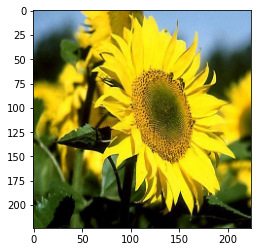

In [55]:
#Predicting for one image and displaying the same 
print("Predicition is => {0} : {1}" .format( pred[0], classes[pred[0]]))


flower = X_test[0].reshape(img_size,img_size,3)
plt.imshow(flower, cmap= 'gray')
plt.show()

Text(0.5, 1.0, 'Accuracy Score for MultinomialNB: 0.3639705882352941')

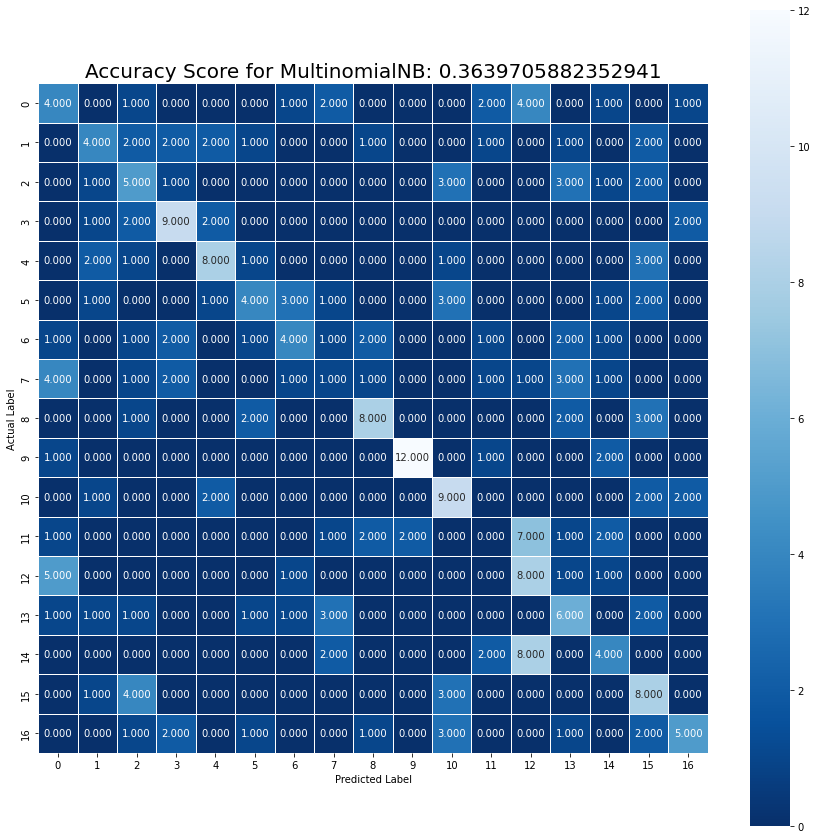

In [56]:
cm = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score for MultinomialNB: {0}'.format(accuracy_score(np.argmax(y_test, axis=1), pred))
plt.title(all_sample_title, size = 20)

In [57]:
# Classification Report
cr = classification_report(np.argmax(y_test, axis=1),pred)
print(cr)

              precision    recall  f1-score   support

           0       0.24      0.25      0.24        16
           1       0.33      0.25      0.29        16
           2       0.25      0.31      0.28        16
           3       0.50      0.56      0.53        16
           4       0.53      0.50      0.52        16
           5       0.36      0.25      0.30        16
           6       0.36      0.25      0.30        16
           7       0.09      0.06      0.07        16
           8       0.53      0.50      0.52        16
           9       0.86      0.75      0.80        16
          10       0.41      0.56      0.47        16
          11       0.00      0.00      0.00        16
          12       0.29      0.50      0.36        16
          13       0.30      0.38      0.33        16
          14       0.29      0.25      0.27        16
          15       0.31      0.50      0.38        16
          16       0.50      0.31      0.38        16

    accuracy              

In [58]:
# Adding Final accuracy value to Results DataFrame
tempResultsDf = pd.DataFrame({'Model':['MultinomialNB'],'Accuracy': (accuracy_score(np.argmax(y_test, axis=1), pred))},index={'1'})
resultsdf = pd.concat([resultsdf, tempResultsDf])
resultsdf

,Model,Accuracy
1,MultinomialNB,0.363971


##### C. Train a model using Neural Network and share performance metrics on test data.

##### Using ImageDataGenerator to avoid the overfitting problem from start for ANN and CNN.

In [59]:
#ImageDataGenerator declaration 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=50,  
                                                          width_shift_range=0.1,  
                                                          height_shift_range=0.1,  
                                                          horizontal_flip=True, 
                                                          shear_range=0.2,
                                                          zoom_range=0.2,  
                                                          fill_mode="nearest")  

# Prepare the generator
datagen.fit(X_train)

In [60]:
ann_batch_size = 32
ann_epochs = 25

In [61]:
# Clear out tensorflow memory
tf.keras.backend.clear_session()

# Initialize Sequential model
ann = tf.keras.models.Sequential()

# Input layer 
ann.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(img_size,img_size,img_depth)))

# Normalize the data
ann.add(tf.keras.layers.BatchNormalization())

# Dense Layer
ann.add(tf.keras.layers.Dense(128,activation='relu'))

# Normalize the data
ann.add(tf.keras.layers.BatchNormalization())

# Flatten layer
ann.add(tf.keras.layers.Flatten())

# Dense Layer
ann.add(tf.keras.layers.Dense(32,activation='relu'))

# Normalize the data
ann.add(tf.keras.layers.BatchNormalization())

#Output layer
ann.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

#Configuring the model for training
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [62]:
# Model summary 
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224, 224, 64)      256       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 224, 224, 128)     8320      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 128)    512       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 6422528)           0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [63]:
# Training the model
ann.fit(datagen.flow(X_train,y_train,batch_size=ann_batch_size),
                  steps_per_epoch=X_train.shape[0]/32,
                  epochs=ann_epochs,
                  validation_data=(X_test,y_test))

Epoch 1/25
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.8806 - acc: 0.1627

C:\Users\Nikhila KG\anaconda3\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


34/34 [==============================] - 330s 10s/step - batch: 16.5000 - size: 32.0000 - loss: 2.8806 - acc: 0.1627 - val_loss: 2.8328 - val_acc: 0.0588
Epoch 2/25
34/34 [==============================] - 323s 9s/step - batch: 16.5000 - size: 32.0000 - loss: 2.4369 - acc: 0.2105 - val_loss: 2.8627 - val_acc: 0.0588
Epoch 3/25
34/34 [==============================] - 329s 10s/step - batch: 16.5000 - size: 32.0000 - loss: 2.1525 - acc: 0.2849 - val_loss: 2.8900 - val_acc: 0.0588
Epoch 4/25
34/34 [==============================] - 308s 9s/step - batch: 16.5000 - size: 32.0000 - loss: 1.9730 - acc: 0.3649 - val_loss: 2.9031 - val_acc: 0.0588
Epoch 5/25
34/34 [==============================] - 330s 10s/step - batch: 16.5000 - size: 32.0000 - loss: 1.8456 - acc: 0.4136 - val_loss: 2.8985 - val_acc: 0.0588
Epoch 6/25
34/34 [==============================] - 307s 9s/step - batch: 16.5000 - size: 32.0000 - loss: 1.6792 - acc: 0.4559 - val_loss: 2.8898 - val_acc: 0.0735
Epoch 7/25
34/34 [======

In [64]:
# Final evaluation of the model
loss, acc = ann.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f%%' % (acc*100))
print('Train Loss: %.3f'% loss)
print()

loss, acc = ann.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f%%' % (acc*100))
print('Test Loss: %.3f'% loss)

Train Accuracy: 78.585%
Train Loss: 0.680

Test Accuracy: 62.868%
Test Loss: 1.067


In [65]:
# Predicting for all of test dataset 
y_pred_ann = np.argmax(ann.predict(X_test),axis=-1)
# Label categorical Conversion
y_test_f = np.argmax(y_test,axis=-1)

C:\Users\Nikhila KG\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0.5, 1.0, 'Accuracy Score for ANN: 0.6286764705882353')

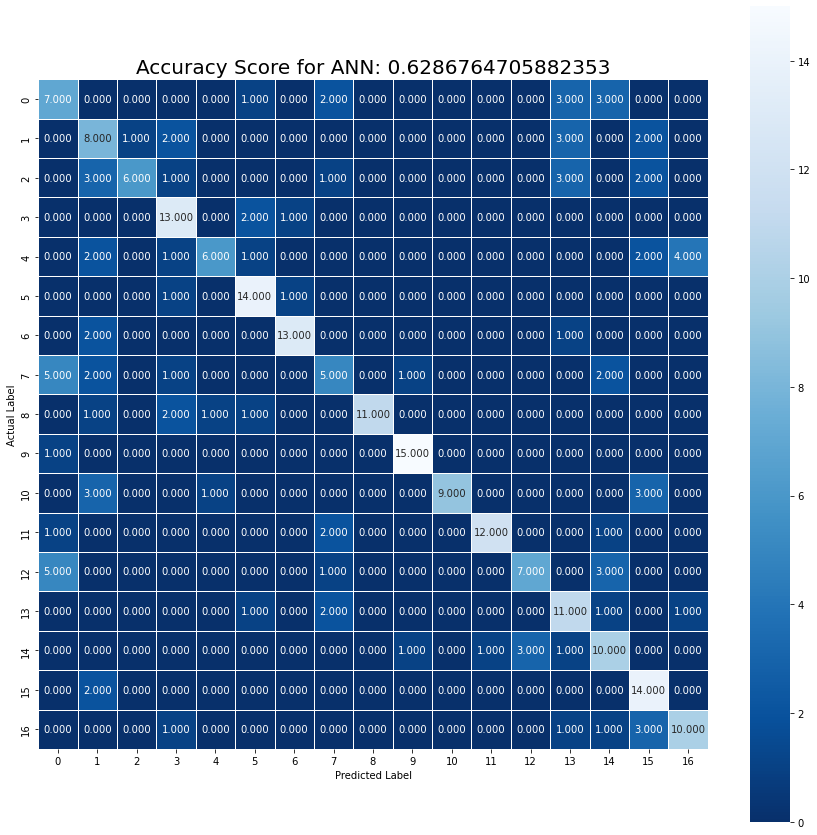

In [66]:
# Confusion Matrix

cm = confusion_matrix(y_test_f,y_pred_ann)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score for ANN: {0}'.format(accuracy_score(y_test_f,y_pred_ann))
plt.title(all_sample_title, size = 20)

In [67]:
# Adding Final accuracy value to Results DataFrame
tempResultsDf = pd.DataFrame({'Model':['ANN'],'Accuracy': ann.evaluate(X_test, y_test, verbose=0)[1]},index={'2'})
resultsdf = pd.concat([resultsdf, tempResultsDf])
resultsdf

,Model,Accuracy
1,MultinomialNB,0.363971
2,ANN,0.628676


##### D. Train a model using a basic CNN and share performance metrics on test data.

In [68]:
cnn_batch_size = 32
cnn_epochs = 25

In [69]:
#Clear any existing model in memory
tf.keras.backend.clear_session()

#Initialize model
cnn = tf.keras.models.Sequential()

#Adding first convolutional layer
cnn.add(tf.keras.layers.Conv2D(32, #Number of filters 
                               kernel_size=(3,3), #Size of the filter
                               activation='relu',
                               input_shape=(img_size,img_size,img_depth)))

#Add MaxPooling layer 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Adding second convolutional layer
cnn.add(tf.keras.layers.Conv2D(32, #Number of filters 
                               kernel_size=(3,3), #Size of the filter
                               activation='relu', padding='same'))

#Add MaxPooling layer 2
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Flatten the output
cnn.add(tf.keras.layers.Flatten())

#Dense layer 1
cnn.add(tf.keras.layers.Dense(256, activation='relu'))

#Add another dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Dense layer 2
cnn.add(tf.keras.layers.Dense(512, activation='relu'))

#Add another dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Dense layer 3
cnn.add(tf.keras.layers.Dense(1024, activation='relu')) #, kernel_regularizer = tf.keras.regularizers.l2( l=0.01)

#Add anoter dropout layer
cnn.add(tf.keras.layers.Dropout(0.25))

#Output layer
cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
#adam_opt = tf.keras.optimizers.Adam(lr=0.00001)
cnn.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,verbose=1, mode='auto')
callback_list = [early_stopping]

C:\Users\Nikhila KG\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [70]:
# Model summary 
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 55, 32)        0         
                                                                 
 flatten (Flatten)           (None, 96800)             0

In [71]:
#Train the model
cnn.fit(datagen.flow(X_train,y_train,batch_size=cnn_batch_size),
                    steps_per_epoch=X_train.shape[0]/32,
                    epochs=cnn_epochs,
                    validation_data=(X_test,y_test),
                    callbacks = callback_list)

Epoch 1/25
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.8372 - acc: 0.0855

C:\Users\Nikhila KG\anaconda3\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


34/34 [==============================] - 27s 770ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.8372 - acc: 0.0855 - val_loss: 2.5350 - val_acc: 0.1654
Epoch 2/25
34/34 [==============================] - 27s 783ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.4354 - acc: 0.1857 - val_loss: 2.1233 - val_acc: 0.3015
Epoch 3/25
34/34 [==============================] - 27s 804ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.1685 - acc: 0.2279 - val_loss: 1.8757 - val_acc: 0.3235
Epoch 4/25
34/34 [==============================] - 27s 806ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.0064 - acc: 0.3125 - val_loss: 1.7542 - val_acc: 0.4007
Epoch 5/25
34/34 [==============================] - 28s 811ms/step - batch: 16.5000 - size: 32.0000 - loss: 1.8424 - acc: 0.3612 - val_loss: 1.6052 - val_acc: 0.4228
Epoch 6/25
34/34 [==============================] - 28s 815ms/step - batch: 16.5000 - size: 32.0000 - loss: 1.7690 - acc: 0.3787 - val_loss: 1.5433 - val_acc: 0.4228
Epoch 7/25
34/3

In [72]:
# Final evaluation of the model
loss, acc = cnn.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f%%' % (acc*100))
print('Train Loss: %.3f'% loss)
print()

loss, acc = cnn.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f%%' % (acc*100))
print('Test Loss: %.3f'% loss)

Train Accuracy: 55.882%
Train Loss: 1.241

Test Accuracy: 50.368%
Test Loss: 1.409


In [73]:
# Predicting for all of test dataset 
y_pred_cnn = np.argmax(cnn.predict(X_test),axis=-1)
# Label categorical Conversion
y_test_f = np.argmax(y_test,axis=-1)

C:\Users\Nikhila KG\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0.5, 1.0, 'Accuracy Score for CNN: 0.5036764705882353')

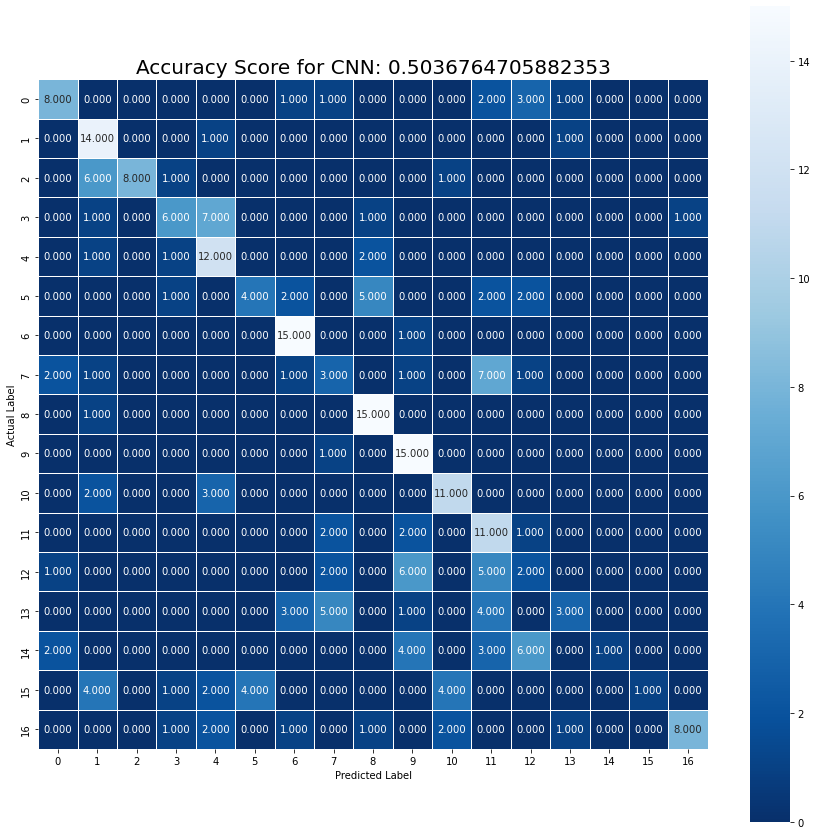

In [74]:
# Confusion Matrix

cm = confusion_matrix(y_test_f,y_pred_cnn)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, fmt = '.3f', linewidths = .5, square = True, cmap='Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score for CNN: {0}'.format(accuracy_score(y_test_f,y_pred_cnn))
plt.title(all_sample_title, size = 20)

In [75]:
# Adding Final accuracy value to Results DataFrame
tempResultsDf = pd.DataFrame({'Model':['CNN'],'Accuracy': cnn.evaluate(X_test, y_test, verbose=0)[1]},index={'3'})
resultsdf = pd.concat([resultsdf, tempResultsDf])
resultsdf

,Model,Accuracy
1,MultinomialNB,0.363971
2,ANN,0.628676
3,CNN,0.503676


##### E. Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.

The shape of image to be predicted is:'(224, 224, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 224, 224, 3)'


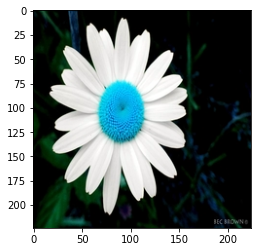

In [76]:
img_pred = cv2.imread('D:/Nikhila/PGP - AIML/2. Projects/8. Computer Vision/PART B/Predict/test img/Prediction.jpg')
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
plt.imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

In [77]:
cnn_predict = np.argmax(cnn.predict(img_predict))

In [78]:
resultsdf = resultsdf.append({'Model':'CNN_pred','Predicted Class': cnn_predict}, ignore_index=True)
resultsdf

C:\Users\Nikhila KG\AppData\Local\Temp\ipykernel_11532\374651948.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'Model':'CNN_pred','Predicted Class': cnn_predict}, ignore_index=True)


,Model,Accuracy,Predicted Class
0,MultinomialNB,0.363971,NaN
1,ANN,0.628676,NaN
2,CNN,0.503676,NaN
3,CNN_pred,NaN,15.0


In [79]:
Labels

{0: 'Daffodil',
 1: 'Snowdrop',
 2: 'LilyValley',
 3: 'Bluebell',
 4: 'Crocus',
 5: 'Iris',
 6: 'Tigerlily',
 7: 'Tulip',
 8: 'Fritillary',
 9: 'Sunflower',
 10: 'Daisy',
 11: 'ColtisFoot',
 12: 'Dandelion',
 13: 'Cowslip',
 14: 'Buttercup',
 15: 'Windflower',
 16: 'Pansy'}

------------------------